<a href="https://colab.research.google.com/github/AjmalSarwary/Time-Series-Optimization-with-Python/blob/master/code/Risk_Parity_12_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U pyportfolioopt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 1.2 MB/s eta 0:00:00


# *```Stress-testing risk parity portfolio across four weakly correlated segments```*

> Short-term U.S. Government Bonds:<br>
SHY - iShares 1-3 Year Treasury Bond ETF<br>
IEF - iShares 7-10 Year Treasury Bond ETF (While typically considered medium-term, it’s included here for better distribution)<br>
BIL - SPDR Bloomberg Barclays 1-3 Month T-Bill ETF<br>
VGSH - Vanguard Short-Term Treasury ETF<br><br>
Long-term U.S. Government Bonds:<br>
TLT - iShares 20+ Year Treasury Bond ETF<br>
VGLT - Vanguard Long-Term Treasury ETF<br>
BLV - Vanguard Long-Term Bond ETF<br>
TLO - SPDR Barclays Long Term Treasury ETF<br><br>
Equity International:<br>
SPY - SPDR S&P 500 ETF Trust (Represents U.S. Equities for broader coverage)<br>
EFA - iShares MSCI EAFE ETF (Developed Markets Excluding U.S. and Canada)<br>
EEM - iShares MSCI Emerging Markets ETF<br>
VEU - Vanguard FTSE All-World ex-US ETF<br><br>
Commodities:<br>
GLD - SPDR Gold Trust<br>
DBC - Invesco DB Commodity Index Tracking Fund<br>
GSG - iShares S&P GSCI Commodity-Indexed Trust<br>
SLV - iShares Silver Trust<br>



In [ ]:
tickers = [
    # Short-term U.S. Government Bonds
    "SHY",  # iShares 1-3 Year Treasury Bond ETF
    "BIL",  # SPDR Bloomberg Barclays 1-3 Month T-Bill ETF
    "IEF",  # iShares 7-10 Year Treasury Bond ETF

    # Long-term Government Bonds
    "TLT",  # iShares 20+ Year Treasury Bond ETF
    "BWX",  # SPDR Bloomberg Barclays International Treasury Bond ETF
    "FLBIX",  # Fidelity Long-Term Bond Index Fund

    # Equity International
    "EFA",  # iShares MSCI EAFE ETF
    "EEM",  # iShares MSCI Emerging Markets ETF
    "VEU",  # Vanguard FTSE All-World ex-US ETF

    # Commodities
    "GLD",  # SPDR Gold Trust
    "SLV",  # iShares Silver Trust
    "DBC",  # Invesco DB Commodity Index Tracking Fund
]



##*```Define data retrieval function```*

In [ ]:
import yfinance as yf
import pandas as pd

def fetch_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)
    adj_close = data['Adj Close']
    return adj_close

In [ ]:
# Fetch data for a specific period
start_date = "2006-01-01"
end_date = "2023-01-01"
adj_close = fetch_data(tickers, start_date, end_date)

[*********************100%%**********************]  12 of 12 completed


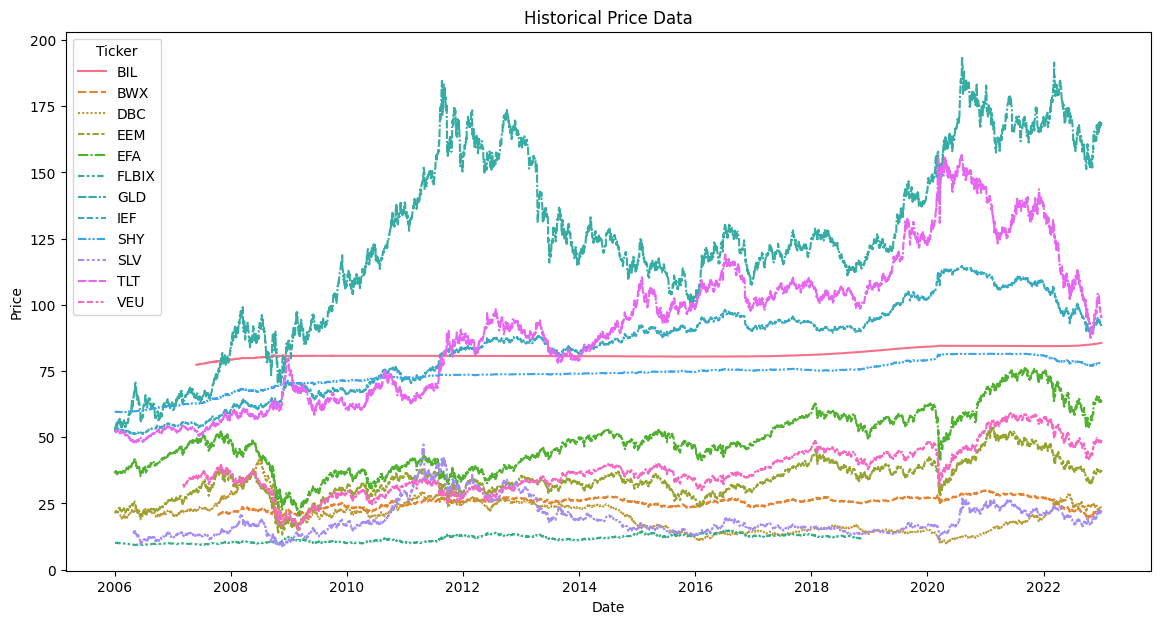

In [ ]:
# Plot historical price data
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 7))
sns.lineplot(data=adj_close)
plt.title('Historical Price Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


##*```Fetch data for out-of-sample optimization periods```*
> 2005 - 2007 (prior to stress test period) <br> 2012 - 2013 (Look-ahead bias)<br> 2015 - 2016 (Look-ahead bias)



In [ ]:
from pypfopt import risk_models, expected_returns
from numpy.linalg import LinAlgError

# Fetch adjusted close prices for 2006-2007
adj_close_2006_2007 = fetch_data(tickers, "2006-01-01", "2007-12-31")

# Calculate expected annualized returns
mu_2006_2007 = expected_returns.mean_historical_return(adj_close_2006_2007)

# Attempting an alternative risk model if sample_cov shows errors
try:
    S_2006_2007 = risk_models.sample_cov(adj_close_2006_2007)
except LinAlgError:
    # Use exponential covariance as a fallback
    S_2006_2007 = risk_models.exp_cov(adj_close_2006_2007)

print(mu_2006_2007)

# Calculate daily returns
daily_returns_2006_2007 = adj_close_2006_2007.pct_change()
# Drop NaN
daily_returns_2006_2007 = daily_returns_2006_2007.dropna()





[*********************100%%**********************]  12 of 12 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['GLD']: OperationalError('database is locked')
/usr/local/lib/python3.10/dist-packages/pypfopt/risk_models.py:70: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(


Ticker
BIL      0.043377
BWX      0.160573
DBC      0.179779
EEM      0.309314
EFA      0.161893
FLBIX    0.002984
GLD      0.000000
IEF      0.061870
SHY      0.054982
SLV      0.036058
TLT      0.051904
VEU      0.213235
dtype: float64


In [ ]:
# Chek for potential issues due to the warning of none-positive-semidefiniteness of cov-matrix

# Check for identical returns
differences = daily_returns_2006_2007.diff()
identical_returns = (differences == 0).all()
print('identical returns: \n', identical_returns, '\n\n')

# Check for collinearity (Vif)
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
  # Add a constant term for the intercept
X = sm.add_constant(daily_returns_2006_2007)
  # Calculate Vif for all values in each column
vif = pd.DataFrame()
vif["Vif"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print('Variance inflation factors: \n ', vif)

print()
# Check for isnulls
print('Sum of InullReturns per Ticker Symbol: \n',adj_close_2006_2007.isnull().sum())


identical returns: 
 Ticker
BIL      False
BWX      False
DBC      False
EEM      False
EFA      False
FLBIX    False
GLD      False
IEF      False
SHY      False
SLV      False
TLT      False
VEU      False
dtype: bool 


Variance inflation factors: 
            Vif features
0    1.402846    const
1    1.460921      BIL
2    3.135555      BWX
3    2.693442      DBC
4   19.033148      EEM
5   16.242339      EFA
6   13.036317    FLBIX
7    4.792743      GLD
8   26.392421      IEF
9    9.430694      SHY
10   6.946974      SLV
11  25.462027      TLT
12  24.066815      VEU

Sum of InullReturns per Ticker Symbol: 
 Ticker
BIL      352
BWX      446
DBC       23
EEM        0
EFA        0
FLBIX      0
GLD        0
IEF        0
SHY        0
SLV       80
TLT        0
VEU      295
dtype: int64


#*```--!!--> Serious Collinearity Issues:```*

### Short-term U.S. Government Bonds
- "IEF" (iShares 7-10 Year Treasury Bond ETF)
    - VIF: 26.392421
    - Isnull: 0

### Long-term Government Bonds
- "TLT" (iShares 20+ Year Treasury Bond ETF)
    - VIF: 25.462027
    - Isnull: 0
- "FLBIX" (Fidelity Long-Term Bond Index Fund)
    - VIF: 13.036317
    - Isnull: 0

### Equity International
- "EFA" (iShares MSCI EAFE ETF)
    - VIF: 16.242339
    - Isnull: 0
- "EEM" (iShares MSCI Emerging Markets ETF)
    - VIF: 19.033148
    - Isnull: 0
- "VEU" (Vanguard FTSE All-World ex-US ETF)
    - VIF: 24.066815
    - Isnull: 295

In [ ]:
# 2012 - 2013
adj_close_2012_2013 = fetch_data(tickers, "2012-01-01", "2013-12-31")
# Calculate expected annualized returns and the annualized sample covariance matrix of daily asset returns
mu_2012_2013 = expected_returns.mean_historical_return(adj_close_2012_2013)
S_2012_2013 = risk_models.sample_cov(adj_close_2012_2013)
print(mu_2012_2013[3:5])
# Calculate daily returns
daily_returns_2012_2013 = adj_close_2012_2013.pct_change()
# Drop NaN
daily_returns_2012_2013 = daily_returns_2012_2013.dropna()

[*********************100%%**********************]  10 of 10 completed

Ticker
EFA    0.184287
GLD   -0.140768
dtype: float64


In [ ]:
# 2015 - 2016
adj_close_2015_2016 = fetch_data(tickers, "2015-01-01", "2016-12-31")
# Calculate expected annualized returns and the annualized sample covariance matrix of daily asset returns
mu_2015_2016 = expected_returns.mean_historical_return(adj_close_2015_2016)
S_2015_2016 = risk_models.sample_cov(adj_close_2015_2016)
print(mu_2015_2016[-2:])
# Calculate daily returns
daily_returns_2015_2016 = adj_close_2015_2016.pct_change()
# Drop NaN
daily_returns_2015_2016 = daily_returns_2015_2016.dropna()

[*********************100%%**********************]  10 of 10 completed


Ticker
SPY    0.065220
TLT   -0.008713
dtype: float64


##*Heatmaps of corrs*

In [ ]:
# Calculate average pairwise correlation for each portfolio from triangle upper excl. diagonal(k=1)
avg_corr_2005_2006 = np.mean(correlation_matrix_2005_2006.values[np.triu_indices(len(correlation_matrix_2005_2006), k=1)])
avg_corr_2012_2013 = np.mean(correlation_matrix_2012_2013.values[np.triu_indices(len(correlation_matrix_2012_2013), k=1)])
avg_corr_2015_2016 = np.mean(correlation_matrix_2015_2016.values[np.triu_indices(len(correlation_matrix_2015_2016), k=1)])
# Print the average pairwise correlation for each portfolio
print(f'Average pairwise correlation for portfolio 1: {avg_corr_2005_2006:.2f}')
print(f'Average pairwise correlation for portfolio 2: {avg_corr_2012_2013:.2f}')
print(f'Average pairwise correlation for portfolio 2: {avg_corr_2015_2016:.2f}')

Average pairwise correlation for portfolio 1: 0.14
Average pairwise correlation for portfolio 2: 0.22
Average pairwise correlation for portfolio 2: 0.18


###*avg corrs look good enough to continue the work*

##*Find optimal weights for Max Sharpe Ratio*

In [ ]:
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import RiskParityPortfolio

# Omptimal weights for mu_2005_2006, S_2005_2006
## Max SR
ef = EfficientFrontier(mu_2005_2006, S_2005_2006)
weights = ef.max_sharpe()
weights = ef.cleaned_weights()
print(pd.DataFrame(weights, index=range(len(weights)))[:1].round(3), '\n')
print(ef.portfolio_performance(verbose=True), '\n')
## Risk Parity
ef = RiskParityPortfolio(mu_2005_2006, S_2005_2006)
weights = ef.cleaned_weights()
print(pd.DataFrame(weights, index=range(len(weights)))[:1].round(3), '\n')
print(ef.portfolio_performance(verbose=True), '\n')

# Omptimal weights for mu_2012_2013, S_2012_2013
ef = EfficientFrontier(mu_2012_2013, S_2012_2013)
weights_2012_2013 = ef.max_sharpe()
cleaned_weights_2012_2013 = ef.clean_weights()
print(pd.DataFrame(cleaned_weights_2012_2013, index=range(len(cleaned_weights_2012_2013)))[:1].round(3), '\n')
print(ef.portfolio_performance(verbose=True), '\n')
# Omptimal weights for mu_2015_2016, S_2015_2016
ef = EfficientFrontier(mu_2015_2016, S_2015_2016)
weights_2015_2016 = ef.max_sharpe()
cleaned_weights_2015_2016 = ef.clean_weights()
print(pd.DataFrame(cleaned_weights_2015_2016, index=range(len(cleaned_weights_2015_2016)))[:1].round(3), '\n')
print(ef.portfolio_performance(verbose=True))

ImportError: cannot import name 'RiskParityPortfolio' from 'pypfopt' (/usr/local/lib/python3.10/dist-packages/pypfopt/__init__.py)

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from itertools import combinations
import random

# Ticker lists for each category
short_term_bonds = [
    "SHY", "BIL", "VGSH", "SPTS", "TUZ", "FIVZ", "SCHO", "TBZ", "VGIT", "SHV",
    "STIP", "ISTB", "FLRN", "GSY", "DTUL", "DTUS", "DFVL", "DFVS", "TYNS", "TYBS"
]

long_term_bonds = [
    "TLT", "VGLT", "BLV", "TLH", "ZROZ", "EDV", "DGP", "UST", "TLO", "LBND",
    "TBT", "TMF", "SBND", "DLBL", "DLBS", "TYD", "TYO", "DTYL", "DTYS", "TBF"
]


international_equities = [
    "EFA", "VWO", "VEA", "IXUS", "ACWX", "VEU", "SCZ", "IEMG", "EEM", "VSS",
    "GWX", "SCHF", "FNDF", "GWL", "DWM", "DIM", "DBAW", "DBEF", "IDEV", "IQDF"
]
commodities = [
    "GLD", "SLV", "DBC", "PPLT", "PALL", "GSG", "USCI", "DBA", "DBB", "JJG",
    "RJI", "CORN", "SOYB", "WEAT", "UGA", "UNG", "UGAZ", "DGAZ", "OIL", "BNO"
]


def fetch_data(tickers):
    try:
        data = yf.download(tickers, start="2005-01-01", end="2023-01-01")
        adj_close = data['Adj Close']
        return adj_close.dropna(how='all')
    except Exception as e:
        print(f"Error fetching data: {e}")
        return pd.DataFrame()

def calculate_vif(dataframe):
    if not dataframe.empty:
        X = sm.add_constant(dataframe)
        vif = pd.DataFrame()
        vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
        vif["features"] = X.columns
        return vif
    return pd.DataFrame()

def rand_combine(attempts=0, max_attempts=10):
    if attempts >= max_attempts:
        print("Maximum attempts reached, no suitable combination found.")
        return []

    selected_short_term = random.sample(short_term_bonds, 3)
    selected_long_term = random.sample(long_term_bonds, 3)
    selected_international = random.sample(international_equities, 3)
    selected_commodities = random.sample(commodities, 3)

    combined_tickers = selected_short_term + selected_long_term + selected_international + selected_commodities
    data = fetch_data(combined_tickers)

    if data.empty:
        print("No data returned, trying another combination.")
        return rand_combine(attempts + 1, max_attempts)

    daily_returns = data.pct_change().dropna()
    if not daily_returns.empty:
        vif_df = calculate_vif(daily_returns)
        if not vif_df.empty and all(vif_df["VIF Factor"] < 10):
            print("Found a suitable combination:", combined_tickers)
            print(vif_df)
            return combined_tickers
        else:
            print("VIF too high, trying another combination.")
            return rand_combine(attempts + 1, max_attempts)
    else:
        print("Empty returns, trying another combination.")
        return rand_combine(attempts + 1, max_attempts)

# Initiate the process with a function call
suitable_combination = rand_combine()


[*********************100%%**********************]  12 of 12 completed
[                       0%%                      ]

VIF too high, trying another combination.


[*********************100%%**********************]  12 of 12 completed

Found a suitable combination: ['SCHO', 'STIP', 'DFVS', 'VGLT', 'DTYS', 'DTYL', 'FNDF', 'IEMG', 'GWL', 'OIL', 'RJI', 'DGAZ']
    VIF Factor features
0     1.004131    const
1     1.110761     DFVS
2     1.062287     DGAZ
3     1.131197     DTYL
4     1.620434     DTYS
5     3.933999     FNDF
6     1.482871      GWL
7     3.269182     IEMG
8     2.717286      OIL
9     2.915087      RJI
10    2.017782     SCHO
11    1.986915     STIP
12    1.959698     VGLT


##```rand_combine() found sets of viable candidates with Vif < 10```
>```python
 Found a suitable combination: ['GSY', 'TYNS', 'DFVS', 'UST', 'DTYS', 'TLH', 'GWL', 'FNDF', 'VSS', 'DBC', 'BNO', 'WEAT']
    VIF Factor features
0     1.008863    const
1     5.556089      BNO
2     6.532593      DBC
3     1.132853     DFVS
4     1.780290     DTYS
5     9.348923     FNDF
6     1.180849      GSY
7     1.485048      GWL
8     7.746490      TLH
9     1.065527     TYNS
10    9.306494      UST
11    8.637018      VSS
12    1.306558     WEAT
Found a suitable combination: ['SCHO', 'STIP', 'DFVS', 'VGLT', 'DTYS', 'DTYL', 'FNDF', 'IEMG', 'GWL', 'OIL', 'RJI', 'DGAZ']
    VIF Factor features
0     1.004131    const
1     1.110761     DFVS
2     1.062287     DGAZ
3     1.131197     DTYL
4     1.620434     DTYS
5     3.933999     FNDF
6     1.482871      GWL
7     3.269182     IEMG
8     2.717286      OIL
9     2.915087      RJI
10    2.017782     SCHO
11    1.986915     STIP
12    1.959698     VGLT
```
I will choose the latter.

In [ ]:
tickers =  ['SCHO', 'STIP', 'DFVS', 'VGLT', 'DTYS', 'DTYL', 'FNDF', 'IEMG', 'GWL', 'OIL', 'RJI', 'DGAZ']

In [ ]:
import yfinance as yf
import pandas as pd

def fetch_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)
    adj_close = data['Adj Close']
    return adj_close

#############################################################ää

from pypfopt import risk_models, expected_returns
from numpy.linalg import LinAlgError

# Fetch adjusted close prices for 2006-2007
adj_close_2006_2007 = fetch_data(tickers, "2006-01-01", "2007-12-31")

# Calculate expected annualized returns
mu_2006_2007 = expected_returns.mean_historical_return(adj_close_2006_2007)

# Attempting an alternative risk model if sample_cov shows errors
try:
    S_2006_2007 = risk_models.sample_cov(adj_close_2006_2007)
except LinAlgError:
    # Use exponential covariance as a fallback
    S_2006_2007 = risk_models.exp_cov(adj_close_2006_2007)

print(mu_2006_2007)

# Calculate daily returns
daily_returns_2006_2007 = adj_close_2006_2007.pct_change()
# Drop NaN
daily_returns_2006_2007 = daily_returns_2006_2007.dropna()

[*********************100%%**********************]  12 of 12 completed
ERROR:yfinance:
11 Failed downloads:
ERROR:yfinance:['DTYS', 'RJI', 'DFVS', 'DTYL', 'STIP', 'SCHO', 'DGAZ', 'FNDF', 'IEMG', 'OIL', 'VGLT']: Exception("%ticker%: Data doesn't exist for startDate = 1136091600, endDate = 1199077200")


Ticker
DFVS    0.000000
DGAZ    0.000000
DTYL    0.000000
DTYS    0.000000
FNDF    0.000000
GWL     0.014464
IEMG    0.000000
OIL     0.000000
RJI     0.000000
SCHO    0.000000
STIP    0.000000
VGLT    0.000000
dtype: float64


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import random

# Define your ticker categories here
short_term_bonds = [
    "SHY", "BIL", "VGSH", "SPTS", "TUZ", "FIVZ", "SCHO", "TBZ", "VGIT", "SHV",
    "STIP", "ISTB", "FLRN", "GSY", "DTUL", "DTUS", "DFVL", "DFVS", "TYNS", "TYBS"
]

long_term_bonds = [
    "TLT", "VGLT", "BLV", "TLH", "ZROZ", "EDV", "DGP", "UST", "TLO", "LBND",
    "TBT", "TMF", "SBND", "DLBL", "DLBS", "TYD", "TYO", "DTYL", "DTYS", "TBF"
]


international_equities = [
    "EFA", "VWO", "VEA", "IXUS", "ACWX", "VEU", "SCZ", "IEMG", "EEM", "VSS",
    "GWX", "SCHF", "FNDF", "GWL", "DWM", "DIM", "DBAW", "DBEF", "IDEV", "IQDF"
]
commodities = [
    "GLD", "SLV", "DBC", "PPLT", "PALL", "GSG", "USCI", "DBA", "DBB", "JJG",
    "RJI", "CORN", "SOYB", "WEAT", "UGA", "UNG", "UGAZ", "DGAZ", "OIL", "BNO"
]

# List to track delisted or problematic tickers
delisted = []

def fetch_data(tickers):
    """Fetch adjusted close prices for a list of tickers."""
    try:
        data = yf.download(tickers, start="2005-01-01", end="2023-01-01")
        adj_close = data['Adj Close']
        return adj_close.dropna(how='all')
    except ValueError as e:
        print(f"Error with tickers {tickers}: {e}")
        global delisted
        delisted.extend(tickers)
        return pd.DataFrame()

def calculate_vif(dataframe):
    """Calculate the VIF for a given dataframe."""
    X = sm.add_constant(dataframe)
    return pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
                      index=X.columns)

def attempt_combination():
    """Attempt to find a combination of tickers with acceptable VIF."""
    for attempt in range(20):  # Try up to 10 different combinations
        # Exclude delisted tickers and select 3 tickers from each category
        selected = []
        for category in [short_term_bonds, long_term_bonds, international_equities, commodities]:
            filtered_category = [ticker for ticker in category if ticker not in delisted]
            selected.extend(random.sample(filtered_category, 3))

        data = fetch_data(selected)
        if data.empty:
            print(f"No data returned for {selected}.")
            continue

        daily_returns = data.pct_change().dropna()
        if daily_returns.empty:
            print(f"No returns data for {selected}.")
            continue

        vif = calculate_vif(daily_returns)
        print(f"Attempt #{attempt+1} with tickers {selected}:")
        print(vif)

        if all(vif < 10):
            print("Suitable combination found.")
            return selected
        else:
            print("VIF too high, trying another combination.")

    print("Maximum attempts reached without finding a suitable combination.")
    return []

# Running the attempt to find a suitable combination
suitable_combination = attempt_combination()


[*********************100%%**********************]  12 of 12 completed


Attempt #1 with tickers ['SHV', 'TYNS', 'GSY', 'DLBL', 'DGP', 'TLH', 'GWL', 'DIM', 'EFA', 'JJG', 'SLV', 'UNG']:
const     1.100590
DGP       1.931492
DIM      24.283750
DLBL      1.072270
EFA      23.788491
GSY       1.093143
GWL       1.023897
JJG       1.059686
SHV       1.089379
SLV       2.087735
TLH       1.249121
TYNS      1.132059
UNG       1.020725
dtype: float64
VIF too high, trying another combination.


[*********************100%%**********************]  12 of 12 completed
[                       0%%                      ]

Attempt #2 with tickers ['ISTB', 'SPTS', 'SCHO', 'EDV', 'VGLT', 'TYO', 'DIM', 'EFA', 'GWX', 'UGA', 'GLD', 'SOYB']:
const     1.002180
DIM      17.685118
EDV      23.000998
EFA      18.799560
GLD       1.273411
GWX      10.415170
ISTB      1.831659
SCHO      2.430040
SOYB      1.070614
SPTS      1.191625
TYO       5.531685
UGA       1.215024
VGLT     26.728715
dtype: float64
VIF too high, trying another combination.


[*********************100%%**********************]  12 of 12 completed
[************          25%%                      ]  3 of 12 completed

Attempt #3 with tickers ['BIL', 'TYBS', 'TYNS', 'ZROZ', 'UST', 'DTYL', 'GWL', 'IQDF', 'VEA', 'BNO', 'DBB', 'RJI']:
const     1.029776
BIL       1.001661
BNO       3.978862
DBB       1.453490
DTYL      1.176170
GWL       1.482330
IQDF     15.422839
RJI       4.676636
TYBS      2.296783
TYNS      1.077557
UST       4.315865
VEA      14.973800
ZROZ      5.349461
dtype: float64
VIF too high, trying another combination.


[*********************100%%**********************]  12 of 12 completed
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
[                       0%%                      ]

Attempt #4 with tickers ['ISTB', 'BIL', 'DFVS', 'VGLT', 'SBND', 'TMF', 'VEA', 'GWX', 'VEU', 'DBA', 'USCI', 'UNG']:
const      1.127490
BIL        1.039541
DBA        1.572330
DFVS            NaN
GWX       16.367043
ISTB       5.929714
SBND       6.414286
TMF      169.481072
UNG        1.111325
USCI       1.655327
VEA       46.227205
VEU       40.767539
VGLT     177.333440
dtype: float64
VIF too high, trying another combination.


[*********************100%%**********************]  12 of 12 completed


Attempt #5 with tickers ['VGSH', 'SHV', 'BIL', 'TMF', 'TYD', 'TLH', 'DBAW', 'IQDF', 'DIM', 'DBC', 'UGAZ', 'DGAZ']:
const     1.066710
BIL       1.059753
DBAW      5.338421
DBC       1.327162
DGAZ      2.276167
DIM      10.748414
IQDF     13.023780
SHV       1.235180
TLH      19.184582
TMF      16.146523
TYD       2.493324
UGAZ      2.323793
VGSH      2.113223
dtype: float64
VIF too high, trying another combination.


[*********************100%%**********************]  12 of 12 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['FIVZ']: Exception("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")
[                       0%%                      ]

No returns data for ['GSY', 'VGIT', 'FIVZ', 'LBND', 'TYD', 'DLBS', 'IEMG', 'SCZ', 'VSS', 'JJG', 'WEAT', 'DBB'].


[*********************100%%**********************]  12 of 12 completed
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
[********              17%%                      ]  2 of 12 completed

Attempt #7 with tickers ['SCHO', 'SPTS', 'DTUL', 'BLV', 'TYD', 'LBND', 'IDEV', 'ACWX', 'GWX', 'UGA', 'DBB', 'GLD']:
const     1.005731
ACWX     24.856379
BLV       3.194730
DBB       1.300318
DTUL      1.065880
GLD       1.340647
GWX      13.793563
IDEV     24.556529
LBND           NaN
SCHO      4.299314
SPTS      4.093124
TYD       4.822467
UGA       1.297563
dtype: float64
VIF too high, trying another combination.


[*********************100%%**********************]  12 of 12 completed
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Attempt #8 with tickers ['DFVS', 'TYNS', 'TUZ', 'TBT', 'TYO', 'SBND', 'VWO', 'VEU', 'DBAW', 'PPLT', 'USCI', 'UNG']:
const     1.019381
DBAW     13.103912
DFVS           NaN
PPLT      1.721010
SBND      4.372611
TBT       5.255570
TUZ            NaN
TYNS           NaN
TYO       8.447212
UNG       1.072141
USCI      1.433499
VEU      16.617474
VWO       5.411431
dtype: float64
VIF too high, trying another combination.


[*********************100%%**********************]  12 of 12 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['TLO']: Exception("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


No returns data for ['FLRN', 'DFVL', 'SPTS', 'TLO', 'BLV', 'TBF', 'IXUS', 'DIM', 'VEA', 'PALL', 'SOYB', 'JJG'].


[*********************100%%**********************]  12 of 12 completed


Attempt #10 with tickers ['TYBS', 'DFVL', 'SHV', 'UST', 'TMF', 'EDV', 'GWX', 'DWM', 'VEA', 'GSG', 'RJI', 'JJG']:
const     1.106266
DFVL      1.029452
DWM      37.814871
EDV      23.995163
GSG       6.397620
GWX      16.809542
JJG       1.281933
RJI       6.913704
SHV       1.174765
TMF      29.756592
TYBS      1.942970
UST       5.486479
VEA      62.798749
dtype: float64
VIF too high, trying another combination.


[*********************100%%**********************]  12 of 12 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['TLO']: Exception("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")
[                       0%%                      ]

No returns data for ['TUZ', 'GSY', 'DTUS', 'TLO', 'DLBL', 'DGP', 'VWO', 'FNDF', 'DIM', 'DBC', 'OIL', 'USCI'].


[*********************100%%**********************]  12 of 12 completed
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
[                       0%%                      ]

Attempt #12 with tickers ['DFVL', 'SPTS', 'DTUL', 'SBND', 'TBT', 'UST', 'DIM', 'DBEF', 'VEU', 'WEAT', 'DBC', 'JJG']:
const     1.020727
DBC       1.521718
DBEF      7.504061
DFVL           NaN
DIM      14.390603
DTUL           NaN
JJG       3.487038
SBND      5.127517
SPTS      4.008332
TBT       6.125934
UST      11.684826
VEU      19.092428
WEAT      3.429801
dtype: float64
VIF too high, trying another combination.


[*********************100%%**********************]  12 of 12 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['FIVZ']: Exception("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


No returns data for ['FLRN', 'FIVZ', 'TUZ', 'DLBL', 'LBND', 'TYO', 'IQDF', 'DIM', 'FNDF', 'RJI', 'SOYB', 'UGAZ'].


[*********************100%%**********************]  12 of 12 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['FIVZ']: Exception("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")
[****************      33%%                      ]  4 of 12 completed

No returns data for ['SHY', 'FIVZ', 'SHV', 'TLT', 'TBF', 'VGLT', 'DWM', 'GWX', 'ACWX', 'RJI', 'DBA', 'WEAT'].


[*********************100%%**********************]  12 of 12 completed
[************          25%%                      ]  3 of 12 completed

Attempt #15 with tickers ['DFVL', 'TYBS', 'SCHO', 'TYO', 'TLT', 'DGP', 'DWM', 'IXUS', 'VEU', 'SOYB', 'PALL', 'GSG']:
const     1.005052
DFVL      1.017101
DGP       1.332572
DWM      18.583046
GSG       1.386280
IXUS     44.899974
PALL      1.332952
SCHO      2.054819
SOYB      1.128872
TLT       5.426546
TYBS      2.264838
TYO       5.382772
VEU      58.998877
dtype: float64
VIF too high, trying another combination.


[*********************100%%**********************]  12 of 12 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['TLO']: Exception("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")
[****************      33%%                      ]  4 of 12 completed

No returns data for ['BIL', 'FLRN', 'TYNS', 'TLT', 'LBND', 'TLO', 'FNDF', 'DWM', 'DIM', 'RJI', 'DBA', 'UNG'].


[*********************100%%**********************]  12 of 12 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['TLO']: Exception("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")
[************          25%%                      ]  3 of 12 completed

No returns data for ['TYNS', 'STIP', 'TYBS', 'ZROZ', 'TLO', 'TYD', 'IQDF', 'VEU', 'VWO', 'DBA', 'USCI', 'PALL'].


[*********************100%%**********************]  12 of 12 completed
ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['FIVZ', 'TLO']: Exception("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


No returns data for ['DFVS', 'FIVZ', 'TYBS', 'EDV', 'DLBL', 'TLO', 'GWL', 'SCZ', 'IEMG', 'UGAZ', 'OIL', 'JJG'].


[*********************100%%**********************]  12 of 12 completed
[********              17%%                      ]  2 of 12 completed

Attempt #19 with tickers ['TUZ', 'SHV', 'STIP', 'DTYL', 'DLBS', 'BLV', 'IQDF', 'EFA', 'GWL', 'UNG', 'GSG', 'DBC']:
const     1.041227
BLV       1.638277
DBC      12.063837
DLBS      1.563675
DTYL      1.123905
EFA      13.575657
GSG      11.905881
GWL       1.511707
IQDF     14.025757
SHV       1.072979
STIP      1.664737
TUZ       1.287787
UNG       1.058673
dtype: float64
VIF too high, trying another combination.


[*********************100%%**********************]  12 of 12 completed


Attempt #20 with tickers ['DTUS', 'SHV', 'SCHO', 'TYD', 'ZROZ', 'DTYS', 'GWL', 'IEMG', 'DWM', 'DBC', 'DBA', 'DGAZ']:
const    1.040267
DBA      1.325133
DBC      1.539781
DGAZ     1.031111
DTUS     1.141593
DTYS     1.676504
DWM      3.844827
GWL      1.522677
IEMG     3.321547
SCHO     1.982409
SHV      1.164239
TYD      2.333524
ZROZ     2.380336
dtype: float64
Suitable combination found.


```python
Attempt #11 with tickers ['FLRN', 'DFVL', 'DTUL', 'DLBS', 'DTYS', 'TYO', 'IDEV', 'VWO', 'GWX', 'DBC', 'GLD', 'UNG']:
const     1.005664
DBC       1.385019
DFVL      1.023124
DLBS      2.628867
DTUL      1.045184
DTYS      2.672336
FLRN      1.284911
GLD       1.377940
GWX      13.359651
IDEV     12.279986
TYO       1.425143
UNG       1.060553
VWO       3.573359
Attempt #12 with tickers ['FLRN', 'DFVS', 'SHY', 'TBT', 'TYD', 'TLH', 'DBAW', 'GWL', 'VEU', 'PALL', 'PPLT', 'DBA']:
const     1.004685
DBA       1.139574
DBAW      7.088021
DFVS      1.416799
FLRN      1.530302
GWL       1.536842
PALL      1.491416
PPLT      1.709274
SHY       2.022314
TBT      11.700002
TLH      14.552876
TYD       2.511492
VEU       8.550906
dtype: float64
Attempt #20 with tickers ['DTUS', 'SHV', 'SCHO', 'TYD', 'ZROZ', 'DTYS', 'GWL', 'IEMG', 'DWM', 'DBC', 'DBA', 'DGAZ']:
const    1.040267
DBA      1.325133
DBC      1.539781
DGAZ     1.031111
DTUS     1.141593
DTYS     1.676504
DWM      3.844827
GWL      1.522677
IEMG     3.321547
SCHO     1.982409
SHV      1.164239
TYD      2.333524
ZROZ     2.380336
dtype: float64
Suitable combination found.
```

In [ ]:
tickers= ['DTUS', 'SHV', 'SCHO', 'TYD', 'ZROZ', 'DTYS', 'GWL', 'IEMG', 'DWM', 'DBC', 'DBA', 'DGAZ']

In [ ]:
import yfinance as yf
import pandas as pd

def fetch_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)
    adj_close = data['Adj Close']
    return adj_close

#############################################################ää

from pypfopt import risk_models, expected_returns
from numpy.linalg import LinAlgError

# Fetch adjusted close prices for 2006-2007
adj_close_2006_2007 = fetch_data(tickers, "2006-01-01", "2007-12-31")

# Calculate expected annualized returns
mu_2006_2007 = expected_returns.mean_historical_return(adj_close_2006_2007)

# Attempting an alternative risk model if sample_cov shows errors
try:
    S_2006_2007 = risk_models.sample_cov(adj_close_2006_2007)
except LinAlgError:
    # Use exponential covariance as a fallback
    S_2006_2007 = risk_models.exp_cov(adj_close_2006_2007)

print(mu_2006_2007)

# Calculate daily returns
daily_returns_2006_2007 = adj_close_2006_2007.pct_change()
# Drop NaN
daily_returns_2006_2007 = daily_returns_2006_2007.dropna()

[*********************100%%**********************]  12 of 12 completed
ERROR:yfinance:
7 Failed downloads:
ERROR:yfinance:['TYD', 'DTUS', 'DTYS', 'SCHO', 'DGAZ', 'IEMG', 'ZROZ']: Exception("%ticker%: Data doesn't exist for startDate = 1136091600, endDate = 1199077200")


Ticker
DBA     0.345117
DBC     0.179779
DGAZ    0.000000
DTUS    0.000000
DTYS    0.000000
DWM     0.263568
GWL     0.014464
IEMG    0.000000
SCHO    0.000000
SHV     0.052066
TYD     0.000000
ZROZ    0.000000
dtype: float64


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from itertools import combinations
import random



# Define your ticker categories here
short_term_bonds = [
    "SHY", "BIL", "VGSH", "SPTS", "TUZ", "FIVZ", "SCHO", "TBZ", "VGIT", "SHV",
    "STIP", "ISTB", "FLRN", "GSY", "DTUL", "DTUS", "DFVL", "DFVS", "TYNS", "TYBS"
]

long_term_bonds = [
    "TLT", "VGLT", "BLV", "TLH", "ZROZ", "EDV", "DGP", "UST", "TLO", "LBND",
    "TBT", "TMF", "SBND", "DLBL", "DLBS", "TYD", "TYO", "DTYL", "DTYS", "TBF"
]


international_equities = [
    "EFA", "VWO", "VEA", "IXUS", "ACWX", "VEU", "SCZ", "IEMG", "EEM", "VSS",
    "GWX", "SCHF", "FNDF", "GWL", "DWM", "DIM", "DBAW", "DBEF", "IDEV", "IQDF"
]
commodities = [
    "GLD", "SLV", "DBC", "PPLT", "PALL", "GSG", "USCI", "DBA", "DBB", "JJG",
    "RJI", "CORN", "SOYB", "WEAT", "UGA", "UNG", "UGAZ", "DGAZ", "OIL", "BNO"
]

# List to track delisted or problematic tickers
delisted = []



def calculate_vif(dataframe):
    """Calculate the VIF for a given dataframe."""
    X = sm.add_constant(dataframe)
    return pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
                      index=X.columns)






# Define your ticker categories here as shown previously

def fetch_data(tickers, start_date, end_date):
    """Fetch adjusted close prices for given tickers within a date range."""
    try:
        data = yf.download(tickers, start=start_date, end=end_date)
        adj_close = data['Adj Close']
        # Check for columns with only NaN values indicating no data fetched for the ticker
        valid_data = adj_close.dropna(axis=1, how='all')
        # Identify tickers with no data fetched
        no_data_tickers = set(tickers) - set(valid_data.columns)
        return valid_data, no_data_tickers
    except Exception as e:
        print(f"Error fetching data: {e}")
        return pd.DataFrame(), set(tickers)

def attempt_combinations(max_attempts=20):
    attempts = 0
    while attempts < max_attempts:
        attempts += 1
        print(f"Attempt #{attempts}")

        # Convert sets to lists to avoid deprecation warning and ensure 3 tickers from each category
        combined_tickers = random.sample(list(set(short_term_bonds) - delisted), 3) + \
                           random.sample(list(set(long_term_bonds) - delisted), 3) + \
                           random.sample(list(set(international_equities) - delisted), 3) + \
                           random.sample(list(set(commodities) - delisted), 3)

        data, no_data_tickers = fetch_data(combined_tickers, "2006-01-01", "2007-12-31")
        delisted.update(no_data_tickers)  # Update the delisted set

        # Ensure we have 12 tickers after fetching data
        if not data.empty and len(data.columns) == 12:
            daily_returns = data.pct_change().dropna()
            vif = calculate_vif(daily_returns)
            print(f"Tickers: {list(data.columns)}\nVIF:\n{vif}\n")
            if all(vif < 10):
                print("Found a suitable combination with VIF < 10.")
                break
        else:
            print("Could not fetch sufficient data for a full set of tickers, retrying...")

        if attempts == max_attempts:
            print("Maximum attempts reached, no suitable combination found.")


attempt_combinations()


Attempt #1


TypeError: unsupported operand type(s) for -: 'set' and 'list'